# Notebook 1: DBSCAN Example

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from epic_clustering.scoring import weighted_v_score

all_colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
              'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
              'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
all_colors = all_colors*10

## Roadmap

Our plan is to load some data and try to cluster it with Density-Based Spatial Clustering of Applications with Noise ("DBSCAN")

## 1. Load a CSV file

First, we load one of the CSV files. The exact way you do this will differ between a local notebook and a Kaggle notebook.

In [2]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

In [3]:
events = pd.read_csv(csv_files[0])

## 2. Initial Inspection

Let's examine the dataframe and see what is available.

In [4]:
events.head()

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,clusterID,Efrac,uniqueID
0,27000,0,1895,0.261049,17.51,82,60,0,117.543274,27.425,365.28,11509158343811193875,1.0,-6937585729898357741
1,27000,1,1895,1.218229,12.57,38,42,0,-82.629840,-62.575,363.28,17828652613631594586,1.0,-618091460077957030
2,27000,2,1895,0.983161,12.61,38,43,0,-82.629840,-67.425,365.28,17828652613631594586,1.0,5343361554445887269
3,27000,3,1895,0.404564,12.57,45,42,0,-77.370160,-62.575,361.28,17828652613631594586,1.0,-7175626205880516806
4,27000,4,1895,0.393017,13.46,39,43,1,-87.543280,-67.425,383.28,17828652613631594586,1.0,-3965530794151426912


In [5]:
event = events[events['event'] == events.iloc[0]['event']]

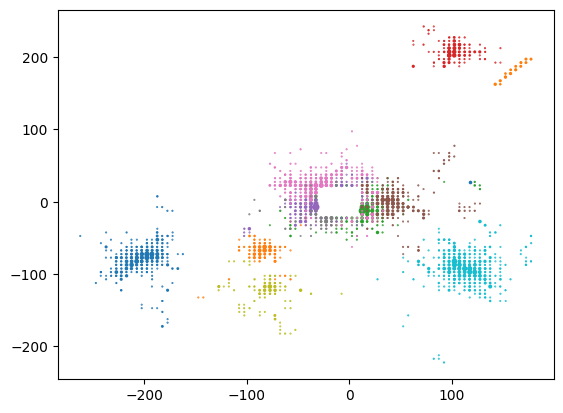

In [6]:
for i, particle in enumerate(event['clusterID'].unique()):
    particle_df = event[event['clusterID'] == particle]
    plt.scatter(particle_df['posx'], particle_df['posy'], label=f'Particle {i}', s=particle_df['E']**(1/2)*5)

In [9]:
event["posz"]

0       365.28000
1       363.28000
2       365.28000
3       361.28000
4       383.28000
          ...    
1890    375.28000
1891    363.28000
1892    471.27997
1893    409.28000
1894    373.28000
Name: posz, Length: 1895, dtype: float64

In [47]:
def cartesian_to_spherical(x, z, y, z_offset=0):
    z = z - z_offset
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    phi = np.arctan2(y, x)
    
    return r, theta, phi

In [30]:
# Convert posx, posy, posz to spherical coordinates
event['r'], event['theta'], event['phi'] = cartesian_to_spherical(event["posx"], event["posy"], event["posz"])

/tmp/ipykernel_110268/3828647326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['r'], event['theta'], event['phi'] = cartesian_to_spherical(event["posx"], event["posy"], event["posz"])


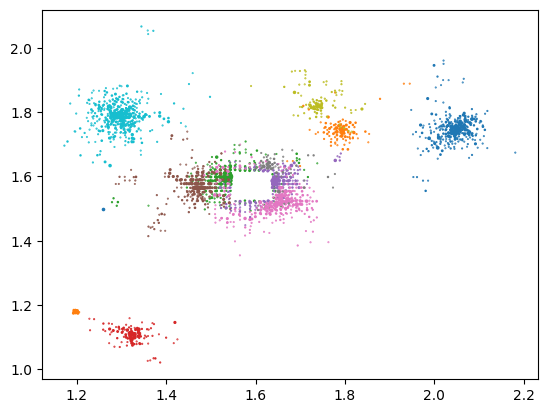

In [31]:
for i, particle in enumerate(event['clusterID'].unique()):
    particle_df = event[event['clusterID'] == particle]
    plt.scatter(particle_df['phi'], particle_df['theta'], label=f'Particle {i}', s=particle_df['E']**(1/2)*5)

/tmp/ipykernel_110268/4005750008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['r'], event['theta'], event['phi'] = cartesian_to_spherical(event["posx"], event["posy"], event["posz"], z_offset = z_offset)


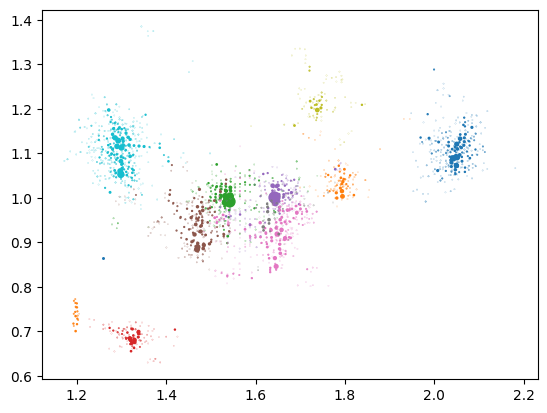

-300


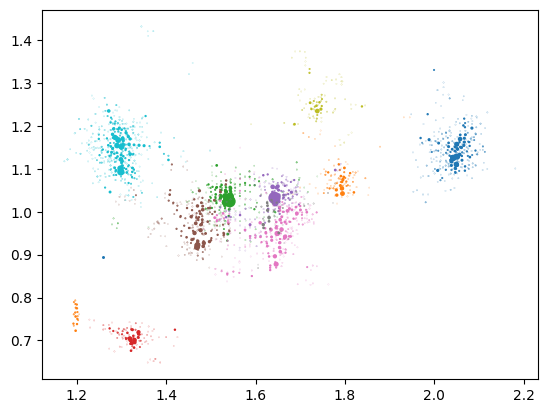

-280


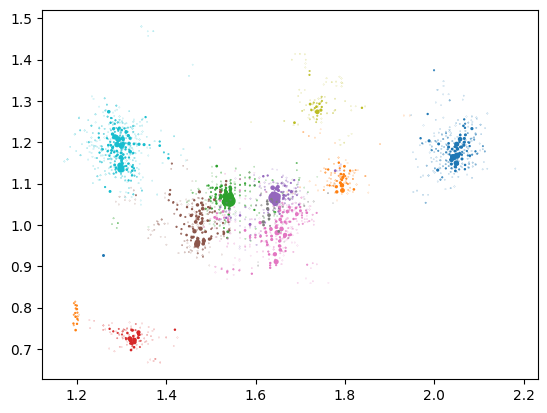

-260


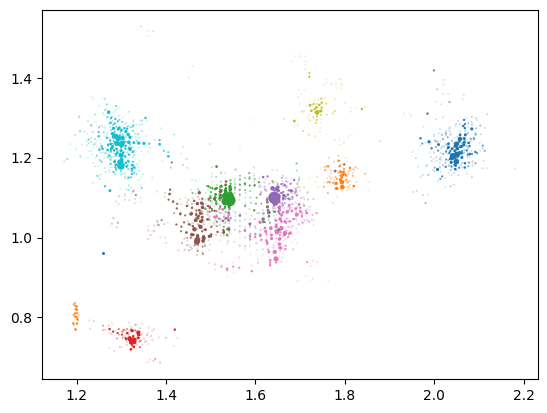

-240


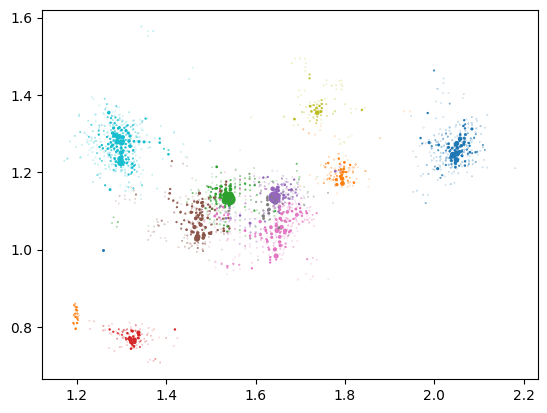

-220


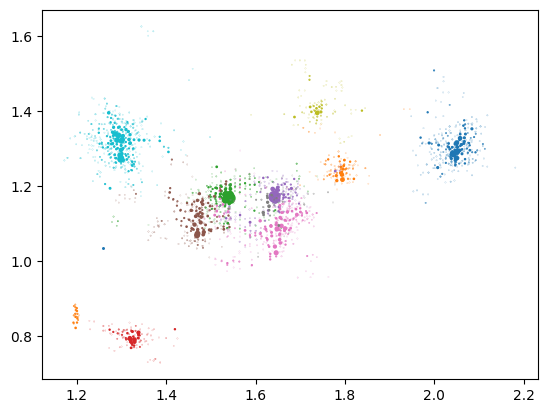

-200


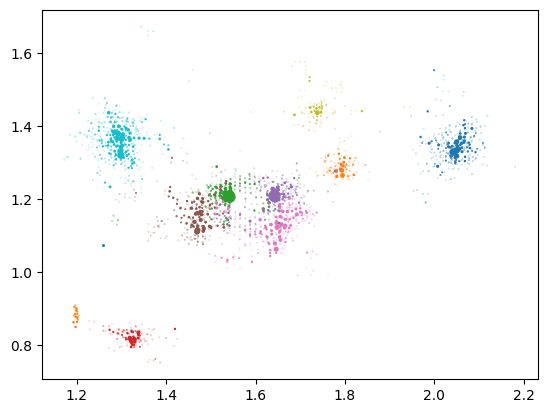

-180


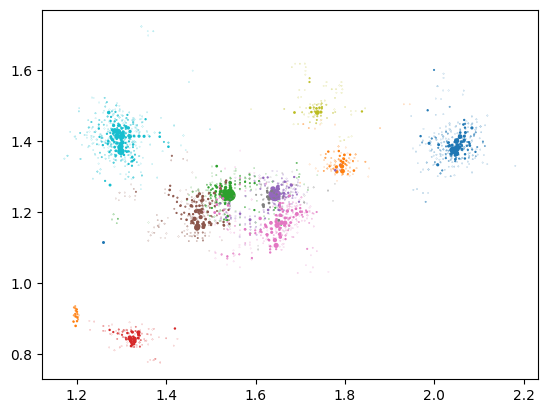

-160


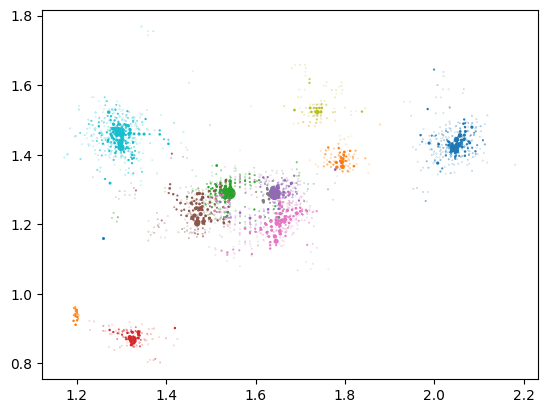

-140


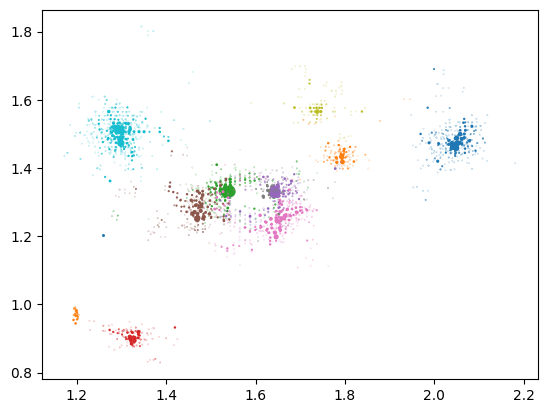

-120


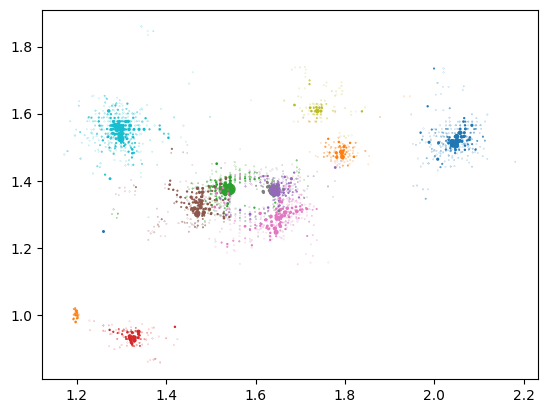

-100


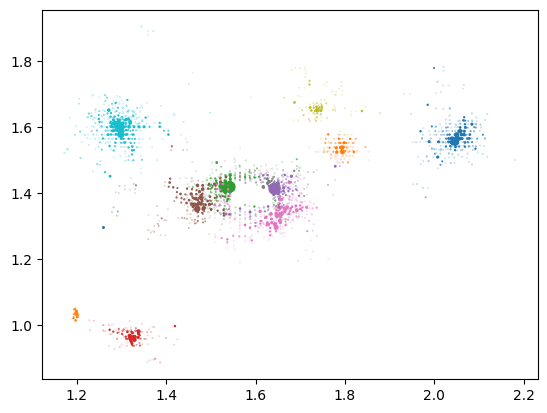

-80


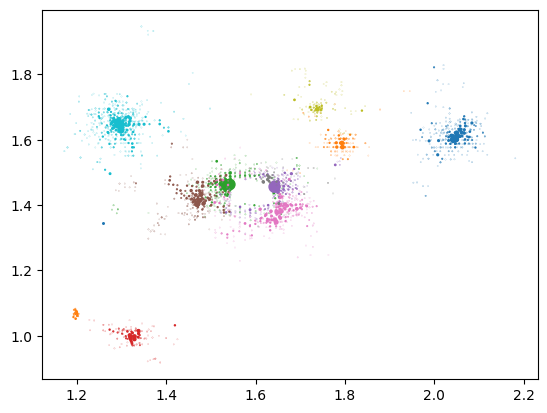

-60


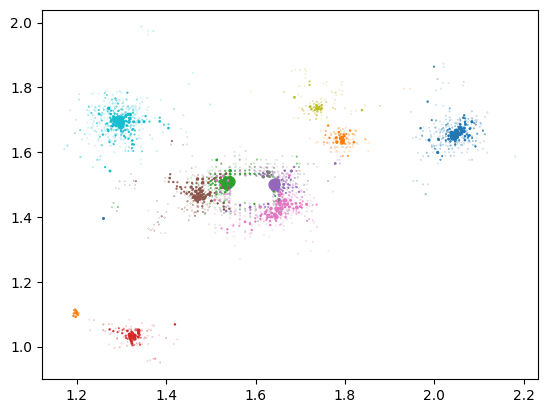

-40


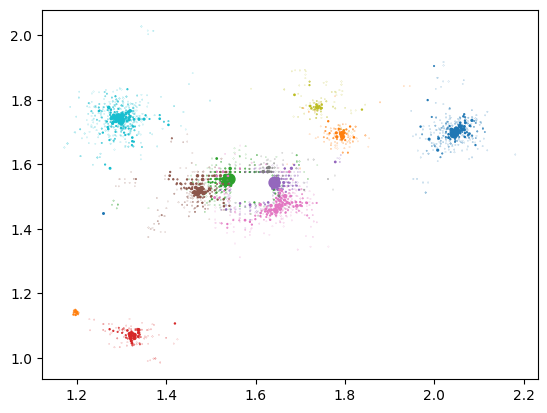

-20


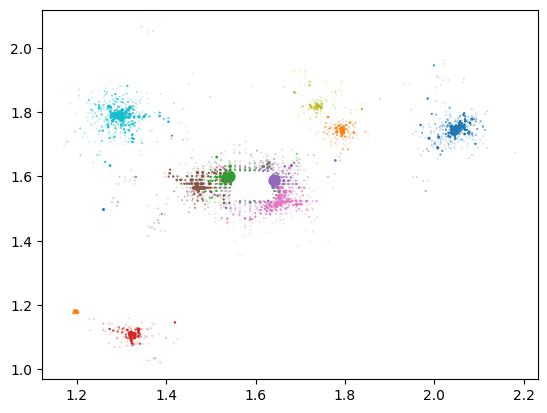

0


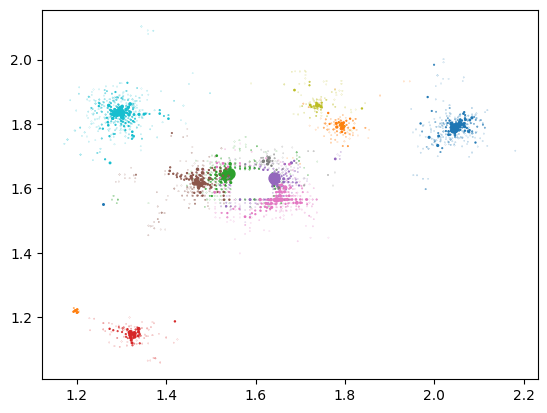

20


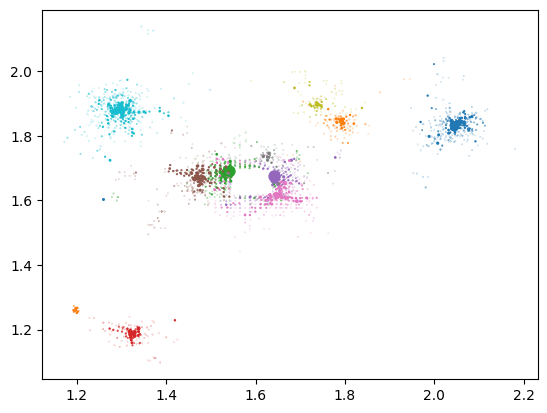

40


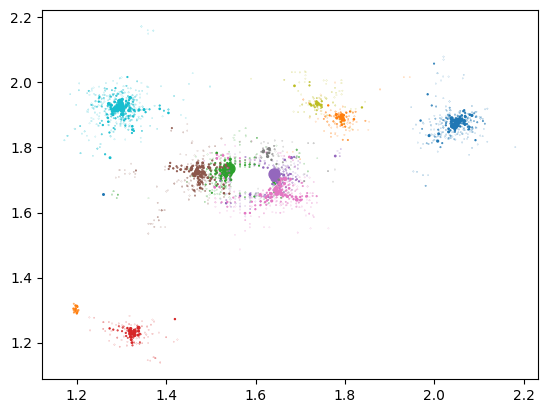

60


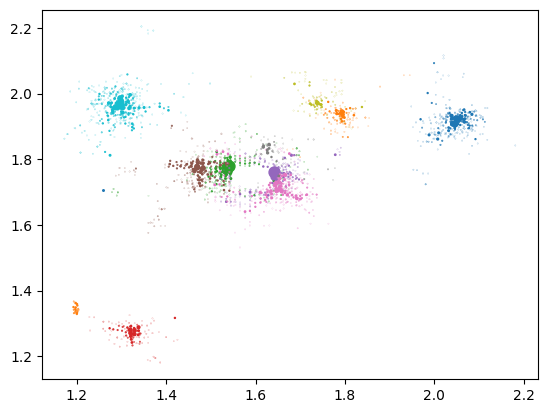

80


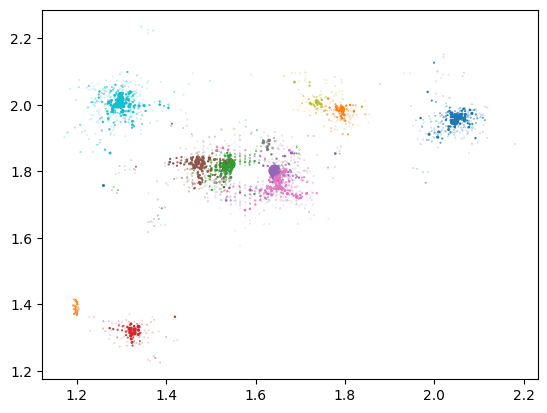

100


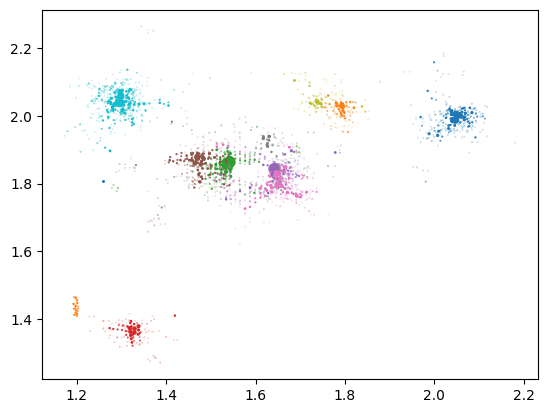

120


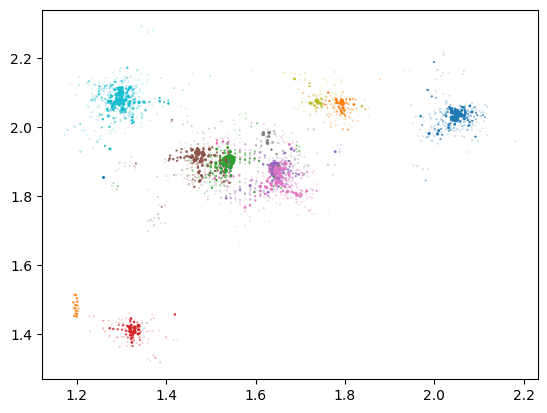

140


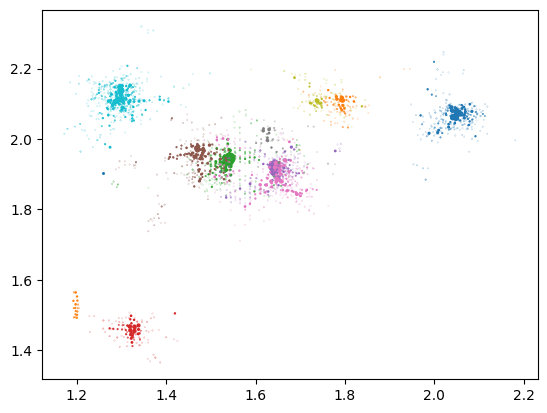

160


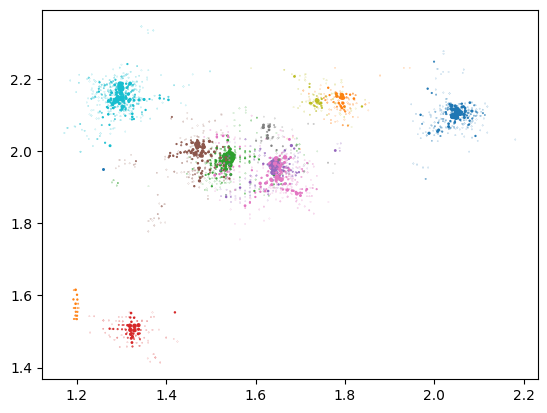

180


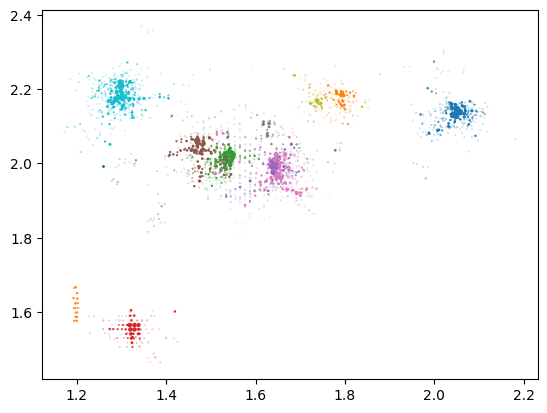

200


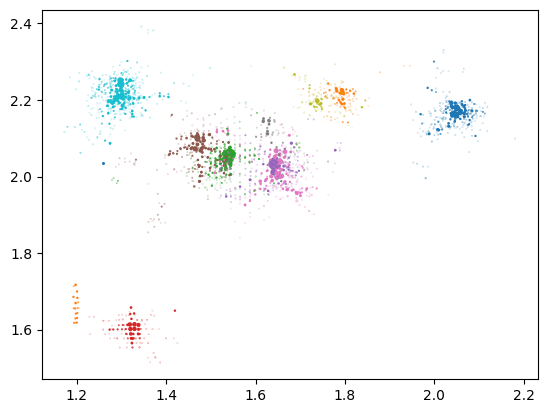

220


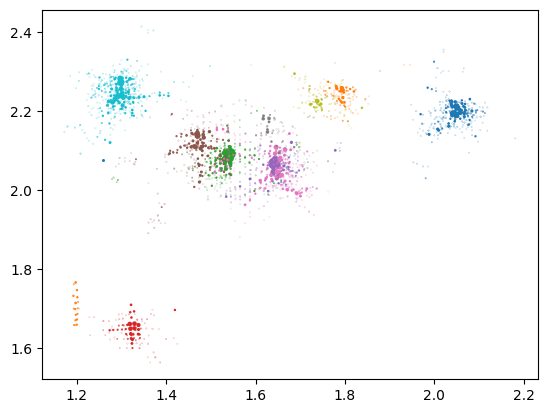

240


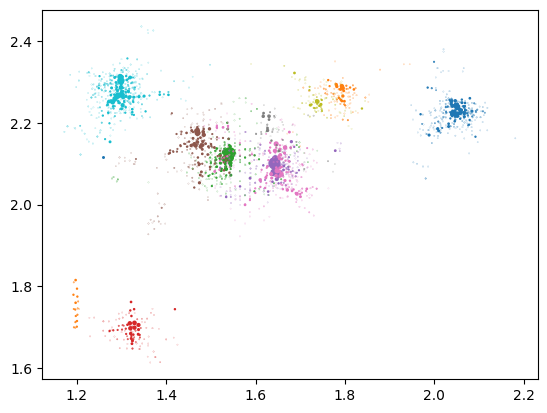

260


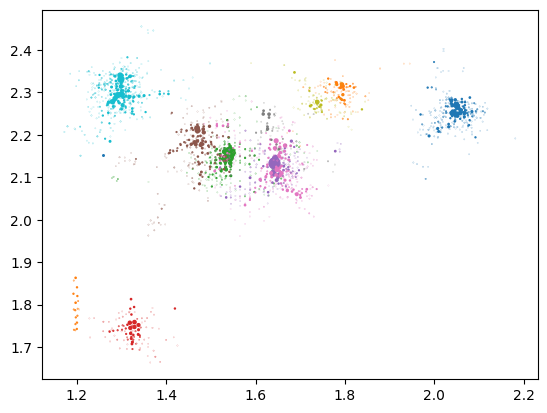

280


In [53]:
for z_offset in np.arange(-300, 300, 20):
    event['r'], event['theta'], event['phi'] = cartesian_to_spherical(event["posx"], event["posy"], event["posz"], z_offset = z_offset)
    for i, particle in enumerate(event['clusterID'].unique()):
        particle_df = event[event['clusterID'] == particle]
        plt.scatter(particle_df['phi'], particle_df['theta'], label=f'Particle {i}', s=particle_df['E']*5)
    plt.show()
    print(z_offset)

## 4. Explore Energy-weighted DBSCAN

In [32]:
best_score = 0
best_eps = 0
best_min_samples = 0
best_labels = None
for eps in range(1, 40):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(event[['posx', 'posy']], sample_weight=event['E'])
        homogeneity, completeness, vscore = weighted_v_score(labels_true=event['clusterID'], labels_pred=labels, labels_weight=event['E'])
        if vscore > best_score:
            best_score = vscore
            best_eps = eps
            best_min_samples = min_samples
            best_labels = labels
            print(f"Best V-Score: {best_score} \nBest eps: {best_eps} \nBest min_samples: {best_min_samples}")

Best V-Score: 0.4996546459656723 
Best eps: 1 
Best min_samples: 1
Best V-Score: 0.6589145663197926 
Best eps: 5 
Best min_samples: 1
Best V-Score: 0.7524823733986102 
Best eps: 6 
Best min_samples: 1
Best V-Score: 0.762408890419704 
Best eps: 7 
Best min_samples: 1
Best V-Score: 0.7714197568132614 
Best eps: 8 
Best min_samples: 1
Best V-Score: 0.7762954968164965 
Best eps: 10 
Best min_samples: 1
Best V-Score: 0.7843550856385034 
Best eps: 11 
Best min_samples: 2
Best V-Score: 0.8004256121002749 
Best eps: 12 
Best min_samples: 2
Best V-Score: 0.811513399200797 
Best eps: 15 
Best min_samples: 2
Best V-Score: 0.8160218673448564 
Best eps: 18 
Best min_samples: 4
Best V-Score: 0.8163573580453676 
Best eps: 18 
Best min_samples: 5


In [46]:
best_score = 0
best_eps = 0
best_min_samples = 0
best_labels = None
for eps in np.linspace(0.001, 0.02, 10):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(event[['phi', 'theta']]/[2, 2], sample_weight=event['E'])
        homogeneity, completeness, vscore = weighted_v_score(labels_true=event['clusterID'], labels_pred=labels, labels_weight=event['E'])
        if vscore > best_score:
            best_score = vscore
            best_eps = eps
            best_min_samples = min_samples
            best_labels = labels
            print(f"Best V-Score: {best_score} \nBest eps: {best_eps} \nBest min_samples: {best_min_samples}")

Best V-Score: 0.46042041650651216 
Best eps: 0.001 
Best min_samples: 1
Best V-Score: 0.5914667739488918 
Best eps: 0.003111111111111111 
Best min_samples: 1
Best V-Score: 0.7741749421989891 
Best eps: 0.005222222222222222 
Best min_samples: 1
Best V-Score: 0.7804919492525308 
Best eps: 0.009444444444444443 
Best min_samples: 1
Best V-Score: 0.8028933223321717 
Best eps: 0.011555555555555555 
Best min_samples: 1
Best V-Score: 0.8161733232038019 
Best eps: 0.013666666666666667 
Best min_samples: 1


In [43]:
best_score = 0
best_eps = 0
best_min_samples = 0
best_labels = None
for eps in np.linspace(0.01, 0.1, 10):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(event[['phi', 'theta', 'r']]/[2, 2, 100], sample_weight=event['E'])
        homogeneity, completeness, vscore = weighted_v_score(labels_true=event['clusterID'], labels_pred=labels, labels_weight=event['E'])
        if vscore > best_score:
            best_score = vscore
            best_eps = eps
            best_min_samples = min_samples
            best_labels = labels
            print(f"Best V-Score: {best_score} \nBest eps: {best_eps} \nBest min_samples: {best_min_samples}")

Best V-Score: 0.45631913813652714 
Best eps: 0.01 
Best min_samples: 1
Best V-Score: 0.5512921821719068 
Best eps: 0.020000000000000004 
Best min_samples: 1
Best V-Score: 0.6319285975936136 
Best eps: 0.030000000000000006 
Best min_samples: 1
Best V-Score: 0.6761127935123714 
Best eps: 0.04000000000000001 
Best min_samples: 1
Best V-Score: 0.6991228785936138 
Best eps: 0.06000000000000001 
Best min_samples: 1


/tmp/ipykernel_1877156/1688689302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['labels'] = best_labels


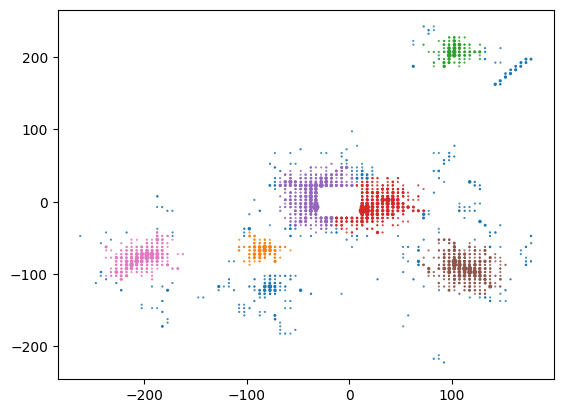

In [63]:
event['labels'] = best_labels
# Plot clusters with label colors
for i, label in enumerate(np.unique(best_labels)):
    plt.scatter(event[event['labels'] == label]['posx'], event[event['labels'] == label]['posy'],  label=f'Cluster {i}', s=event[event['labels'] == label]['E']**(1/2)*5)

We see that the large central cluster, which the vanilla DBSCAN failed to split, has now been handled much better.

## 5. 3D Energy-weighted DBSCAN

This works really nicely in 2D. Recall that the 3D image is less clear - can DBSCAN make sense of it?

In [64]:
best_score = 0
best_eps = 0
best_min_samples = 0
best_labels = None
for eps in range(1, 40):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(event[['posx', 'posy', 'posz']], sample_weight=event['E'])
        homogeneity, completeness, vscore = weighted_v_score(labels_true=event['clusterID'], labels_pred=labels, labels_weight=event['E'])
        if vscore > best_score:
            best_score = vscore
            best_eps = eps
            best_min_samples = min_samples
            best_labels = labels
            print(f"Best V-Score: {best_score} \nBest eps: {best_eps} \nBest min_samples: {best_min_samples}")

Best V-Score: 0.42026814804759416 
Best eps: 1 
Best min_samples: 1
Best V-Score: 0.4246444088214579 
Best eps: 2 
Best min_samples: 1
Best V-Score: 0.42768589935103146 
Best eps: 4 
Best min_samples: 1
Best V-Score: 0.46392543068483527 
Best eps: 5 
Best min_samples: 1
Best V-Score: 0.5459947735991724 
Best eps: 6 
Best min_samples: 1
Best V-Score: 0.6003313574800141 
Best eps: 7 
Best min_samples: 1
Best V-Score: 0.6801025224205562 
Best eps: 8 
Best min_samples: 1
Best V-Score: 0.6974173934720512 
Best eps: 9 
Best min_samples: 1
Best V-Score: 0.7530856500355941 
Best eps: 10 
Best min_samples: 1
Best V-Score: 0.7648164271744547 
Best eps: 11 
Best min_samples: 1
Best V-Score: 0.7673073509548114 
Best eps: 13 
Best min_samples: 1
Best V-Score: 0.7946821183099301 
Best eps: 13 
Best min_samples: 2
Best V-Score: 0.8050939722189437 
Best eps: 14 
Best min_samples: 2
Best V-Score: 0.8132636378226669 
Best eps: 17 
Best min_samples: 1
Best V-Score: 0.8191093825034189 
Best eps: 18 
Best 

/tmp/ipykernel_1877156/1688689302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['labels'] = best_labels


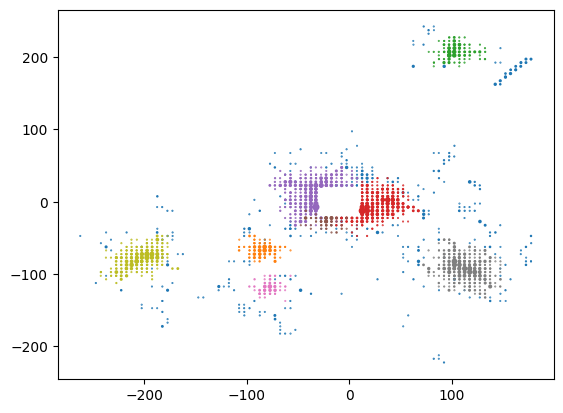

In [65]:
event['labels'] = best_labels
# Plot clusters with label colors
for i, label in enumerate(np.unique(best_labels)):
    plt.scatter(event[event['labels'] == label]['posx'], event[event['labels'] == label]['posy'],  label=f'Cluster {i}', s=event[event['labels'] == label]['E']**(1/2)*5)

3D DBSCAN **slightly** beats out 2D DBSCAN. This is an encouraging sign that if we can figure out how to handle the extra features (z, E, T) correctly, we should be able to out-do the 2D clustering.

## 6. 4D DBSCAN

Why not?

In [68]:
best_score = 0
best_eps = 0
best_min_samples = 0
best_labels = None
for eps in range(1, 40):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(event[['posx', 'posy', 'posz', 'T']], sample_weight=event['E'])
        homogeneity, completeness, vscore = weighted_v_score(labels_true=event['clusterID'], labels_pred=labels, labels_weight=event['E'])
        if vscore > best_score:
            best_score = vscore
            best_eps = eps
            best_min_samples = min_samples
            best_labels = labels
            print(f"Best V-Score: {best_score} \nBest eps: {best_eps} \nBest min_samples: {best_min_samples}")

Best V-Score: 0.42026814804759416 
Best eps: 1 
Best min_samples: 1
Best V-Score: 0.4239426983270138 
Best eps: 3 
Best min_samples: 1
Best V-Score: 0.459720279579115 
Best eps: 5 
Best min_samples: 1
Best V-Score: 0.5332050367927706 
Best eps: 6 
Best min_samples: 1
Best V-Score: 0.5957537762428592 
Best eps: 7 
Best min_samples: 1
Best V-Score: 0.6657937712235181 
Best eps: 8 
Best min_samples: 1
Best V-Score: 0.6903133956911144 
Best eps: 9 
Best min_samples: 1
Best V-Score: 0.7404138998013252 
Best eps: 10 
Best min_samples: 1
Best V-Score: 0.7547196870627454 
Best eps: 11 
Best min_samples: 1
Best V-Score: 0.7583255364178494 
Best eps: 12 
Best min_samples: 1
Best V-Score: 0.7848018450146412 
Best eps: 13 
Best min_samples: 1
Best V-Score: 0.7935756936260224 
Best eps: 14 
Best min_samples: 1
Best V-Score: 0.7972581352611349 
Best eps: 18 
Best min_samples: 1
Best V-Score: 0.8008145457130863 
Best eps: 20 
Best min_samples: 1


Interestingly, time just confuses this issue, when using an unsupervised clustering algorithm. Hopefully we can use it somehow with a supervised method...